<a href="https://colab.research.google.com/github/YangRui525/Comparing-OAD-and-TIC-Studies/blob/main/BERTopic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
pip install bertopic

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.9/103.9 KB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 KB 10.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 102.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.2/88.2 KB 11.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 662.4/662.4 KB 57.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 78.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 81.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 24.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import os 
import pandas as pd
import numpy as np
from bertopic import BERTopic
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import umap
from umap import UMAP
from sklearn.feature_extraction.text import CountVectorizer
from bertopic.vectorizers import ClassTfidfTransformer
from sentence_transformers import SentenceTransformer

In [ ]:
os.chdir("..")
datapath="/content/drive/MyDrive/Colab Notebooks/data.csv"

In [ ]:
data=pd.read_csv(datapath)
data.shape

(227893, 8)

In [ ]:
data=data.dropna().reset_index(drop=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 195463 entries, 0 to 195462
Data columns (total 8 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Title             195463 non-null  object 
 1   Journal           195463 non-null  object 
 2   Type              195463 non-null  object 
 3   Abstract          195463 non-null  object 
 4   Publication Year  195463 non-null  float64
 5   WoS of Category   195463 non-null  object 
 6   Research Area     195463 non-null  object 
 7   Paper Citation    195463 non-null  int64  
dtypes: float64(1), int64(1), object(6)
memory usage: 11.9+ MB


In [ ]:
data=data.loc[(data["Type"]=="Article")|(data["Type"]=="Review")].reset_index(drop=True)
data.shape

(182303, 8)

In [ ]:
index=np.argwhere(np.array(data['Abstract'].str.lower().str.contains(
    "mimic-ii|mimic-iii|mimic-iv|mimic dataset|mimic ii|mimic iii|mimic iv|eicu|mimic data|medical information mart for intensive care|icu|intensive care unit|eicu-crd|amsterdamumcdb|hirid|pediatric intensive care database|pediatric intensive care unit database"))).T[0]
index.shape

(146727,)

In [ ]:
data=data.loc[index].reset_index(drop=True)
data.shape

(146727, 8)

In [ ]:
data_=data
data_=data_[data_["Publication Year"]>=2003]

In [ ]:
mimic_index=data_.index[data_["Abstract"].str.lower().str.contains(
    "mimic-ii|mimic-iii|mimic-iv|mimic dataset|mimic ii|mimic iii|mimic iv|mimic data|medical information mart for intensive care")]
mimic_index.shape

(1149,)

In [ ]:
data_=data_[data_["Publication Year"]>=2018]

In [ ]:
eicu_index=data_.index[data_["Abstract"].str.lower().str.contains(
    "eicu|eicu-crd")]
eicu_index.shape

(224,)

In [ ]:
data_=data_[data_["Publication Year"]>=2020]

In [ ]:
hirid_index=data_.index[data_["Abstract"].str.lower().str.contains(
    "hirid")]
hirid_index.shape

(1,)

In [ ]:
pediatric_index=data_.index[data_["Abstract"].str.lower().str.contains(
    "pediatric intensive care database|pediatric intensive care unit database")]
pediatric_index.shape

(10,)

In [ ]:
data_=data_[data_["Publication Year"]>=2021]

In [ ]:
amsterdam_index=data_.index[data_["Abstract"].str.lower().str.contains(
    "amsterdamumcdb")]
amsterdam_index.shape

(4,)

In [ ]:
database_index=np.concatenate((mimic_index,eicu_index,hirid_index,pediatric_index,amsterdam_index))
database_index.shape

(1388,)

In [ ]:
database_index=np.unique(database_index)
database_index.shape

(1301,)

In [ ]:
other_index=np.argwhere(np.array(data['Abstract'].str.lower().str.contains("mimic-ii|mimic-iii|mimic-iv|mimic dataset|mimic ii|mimic iii|mimic iv|eicu|mimic data|medical information mart for intensive care|icu|intensive care unit|eicu-crd|amsterdamumcdb|hirid|pediatric intensive care database|pediatric intensive care unit database"))).T[0]
other_index=[i for i in other_index if i not in database_index]
len(other_index)

145426

In [ ]:
umap_model=UMAP(n_neighbors=100,n_components=20,metric="cosine",min_dist=0.0,random_state=37)
vectorizer_model=CountVectorizer(ngram_range=(1,4),stop_words="english")
ctfidf_model=ClassTfidfTransformer(reduce_frequent_words=True)
sentence_model=SentenceTransformer("all-MiniLM-L6-v2")
topic_model=BERTopic(verbose=True,ctfidf_model=ctfidf_model,vectorizer_model=vectorizer_model,umap_model=umap_model,embedding_model=sentence_model,nr_topics=30,low_memory=True,calculate_probabilities=True)

In [ ]:
topics,probs=topic_model.fit_transform(data["Abstract"])

Batches:   0%|          | 0/4586 [00:00<?, ?it/s]

2023-01-26 03:40:01,293 - BERTopic - Transformed documents to Embeddings
2023-01-26 03:50:21,156 - BERTopic - Reduced dimensionality
2023-01-26 05:55:29,843 - BERTopic - Clustered reduced embeddings
2023-01-26 06:12:39,130 - BERTopic - Reduced number of topics from 925 to 31


In [ ]:
topic_model.set_topic_labels({0:"Topic 1",1:"Topic 2",2:"Topic 3",3:"Topic 4",4:"Topic 5",      
                              5:"Topic 6",6:"Topic 7",7:"Topic 8",8:"Topic 9",9:"Topic 10",
                              10:"Topic 11",11:"Topic 12",12:"Topic 13",13:"Topic 14",14:"Topic 15",
                              15:"Topic 16",16:"Topic 17",17:"Topic 18",18:"Topic 19",19:"Topic 20",
                              20:"Topic 21",21:"Topic 22",22:"Topic 23",23:"Topic 24",24:"Topic 25",
                              25:"Topic 26",26:"Topic 27",27:"Topic 28",28:"Topic 29",29:"Topic 30"})

In [ ]:
topic_model.get_topic_info()

,Topic,Count,Name,CustomName
0,-1,100935,-1_patients_care_icu_intensive,-1_patients_care_icu_intensive
1,0,2906,0_sepsis_il_pct_septic,Topic 1
2,1,2704,1_aki_kidney_renal_kidney injury,Topic 2
3,2,2488,2_valve_surgery_bypass_coronary,Topic 3
4,3,2329,3_candida_antifungal_candidemia_albicans,Topic 4
5,4,2294,4_learning_model_machine_machine learning,Topic 5
6,5,2186,5_parents_mothers_nicu_infant,Topic 6
7,6,2153,6_esbl_isolates_pneumoniae_producing,Topic 7
8,7,2041,7_rop_infants_neonatal_birth,Topic 8
9,8,1985,8_catheter_catheters_central_clabsi,Topic 9


In [ ]:
topic_model.get_topics()

{-1: [('patients', 0.1448866503398327),
  ('care', 0.13404789854439708),
  ('icu', 0.12848569604686952),
  ('intensive', 0.12462426048707324),
  ('intensive care', 0.12427643041096845),
  ('study', 0.12280123260483695),
  ('unit', 0.11906522945533493),
  ('mortality', 0.11821547380256497),
  ('hospital', 0.11769914915292144),
  ('care unit', 0.1171752025084239)],
 0: [('sepsis', 0.27332579659105266),
  ('il', 0.2349331769309052),
  ('pct', 0.20688752428615256),
  ('septic', 0.20365692356015097),
  ('levels', 0.19867140754643542),
  ('inflammatory', 0.19382192805883686),
  ('expression', 0.18262226882708676),
  ('crp', 0.16998930870275195),
  ('cells', 0.16756787003509055),
  ('plasma', 0.16651943559026977)],
 1: [('aki', 0.36854096036896355),
  ('kidney', 0.26803538053596204),
  ('renal', 0.2492702459064692),
  ('kidney injury', 0.2290889921121861),
  ('acute kidney', 0.22591782716599376),
  ('acute kidney injury', 0.22391387249500308),
  ('rrt', 0.21009784481870297),
  ('dialysis', 0.

In [ ]:
data

,Title,Journal,Type,Abstract,Publication Year,WoS of Category,Research Area,Paper Citation
0,Worsening severity of vitamin D deficiency is ...,AMERICAN JOURNAL OF SURGERY,Article,BACKGROUND: Vitamin D deficiency is the most c...,2012.0,Surgery,Surgery,104
1,Probiotics versus antibiotic decontamination o...,INTENSIVE CARE MEDICINE,Article,Selective decontamination of the digestive tra...,2011.0,Critical Care Medicine,General & Internal Medicine,48
2,The Parental Experience of Having an Infant in...,JOURNAL OF PERINATAL EDUCATION,Article,The purpose of this systematic review was to e...,2009.0,Education & Educational Research,Education & Educational Research,244
3,Enteral and Parenteral Nutrition at Home,JOURNAL OF THE TURKISH SOCIETY OF INTENSIVE CA...,Article,The evolution of Intensive Care Medicine and i...,2008.0,Critical Care Medicine,General & Internal Medicine,0
4,RISK-FACTORS FOR NOSOCOMIAL PNEUMONIA IN INTEN...,ANAESTHESIST,Article,Sixteen risk factors for nosocomial pneumonia ...,1991.0,Anesthesiology,Anesthesiology,8
...,...,...,...,...,...,...,...,...
146722,Fenestrated endovascular aneurysm repair and o...,JOURNAL OF VASCULAR SURGERY,Article,Objective: The objective of this study was to ...,2019.0,Surgery; Peripheral Vascular Disease,Surgery; Cardiovascular System & Cardiology,10
146723,Outcome associated with prescription of cardia...,ARCHIVES OF CARDIOVASCULAR DISEASES,Article,Background. - Cardiac rehabilitation is strong...,2019.0,Cardiac & Cardiovascular Systems,Cardiovascular System & Cardiology,6
146724,Trimethoprim-sulfamethoxazole vs. colistin or ...,JOURNAL OF GLOBAL ANTIMICROBIAL RESISTANCE,Article,Objectives: This study aimed to assess the eff...,2019.0,Infectious Diseases; Pharmacology & Pharmacy,Infectious Diseases; Pharmacology & Pharmacy,8
146725,"Despite Major Therapeutic Advances, Vena Caval...",WORLD JOURNAL OF SURGERY,Review,Background Penetrating inferior vena caval inj...,2022.0,Surgery,Surgery,0


In [ ]:
topics_num=topic_model.reduce_outliers(data["Abstract"],topics,strategy="embeddings")

In [ ]:
data.insert(0,"Topic_Num"," ")

In [ ]:
data["Topic_Num"]=topics_num

In [ ]:
data["Topic_Num"].value_counts().sort_index()

-1         3
 0      3010
 1      6846
 2      8672
 3      2738
 4      2415
 5      2619
 6      2154
 7     10173
 8      3409
 9      5416
 10     2855
 11     4305
 12    31685
 13     2382
 14     4345
 15     1318
 16     4472
 17     6374
 18     4155
 19     2784
 20     3150
 21     5371
 22     1518
 23     2871
 24     2505
 25      945
 26    14220
 27     1433
 28     1372
 29     1212
Name: Topic_Num, dtype: int64

In [ ]:
fig=topic_model.visualize_heatmap(custom_labels=True)
fig.write_html("/content/drive/MyDrive/Colab Notebooks/cluster.html")

In [ ]:
hierarchical_topics=topic_model.hierarchical_topics(data["Abstract"])

100%|██████████| 29/29 [00:24<00:00,  1.18it/s]


In [ ]:
topic_model.visualize_hierarchy(hierarchical_topics=hierarchical_topics,custom_labels=True)

In [ ]:
database_precentage=(data["Topic_Num"][database_index].value_counts()/data["Abstract"][database_index].shape)*100
database_precentage.sort_index() 

0      0.076864
1      6.917756
2      2.767102
3      0.384320
4     42.275173
6      0.384320
7      0.230592
8      0.076864
9      1.691007
10     0.538048
11     0.076864
12    33.435819
13     0.076864
14     2.152191
15     0.153728
16     0.999231
17     0.076864
18     0.768640
19     0.922367
20     0.076864
21     0.999231
23     0.153728
24     0.153728
26     2.997694
28     1.229823
29     0.384320
Name: Topic_Num, dtype: float64

In [ ]:
database_precentage=[0.076894,6.917756,2.767102,0.384320,42.275173,
                     0,0.384320,0.230592,0.076864,1.691007,
                     0.538048,0.076864,33.435819,0.076864,2.152191,
                     0.153728,0.999231,0.076864,0.768640,0.922367,
                     0.076864,0.999231,0,0.153728,0.153728,
                     0,2.997694,0,1.229823,0.384320]

In [ ]:
sum(database_precentage)

100.00003199999999

In [ ]:
other_precentage=(data["Topic_Num"][other_index].value_counts()/data["Abstract"][other_index].shape)*100
other_precentage=other_precentage.sort_index()[1:]

In [ ]:
other_precentage

0      2.069094
1      4.645662
2      5.938415
3      1.879306
4      1.282439
5      1.800916
6      1.477728
7      6.993247
8      2.343460
9      3.709103
10     1.958384
11     2.959581
12    21.488592
13     1.637259
14     2.968520
15     0.904928
16     3.066164
17     4.382298
18     2.850247
19     1.906124
20     2.165362
21     3.684348
22     1.043830
23     1.972825
24     1.721150
25     0.649815
26     9.751351
27     0.985381
28     0.932433
29     0.829975
Name: Topic_Num, dtype: float64

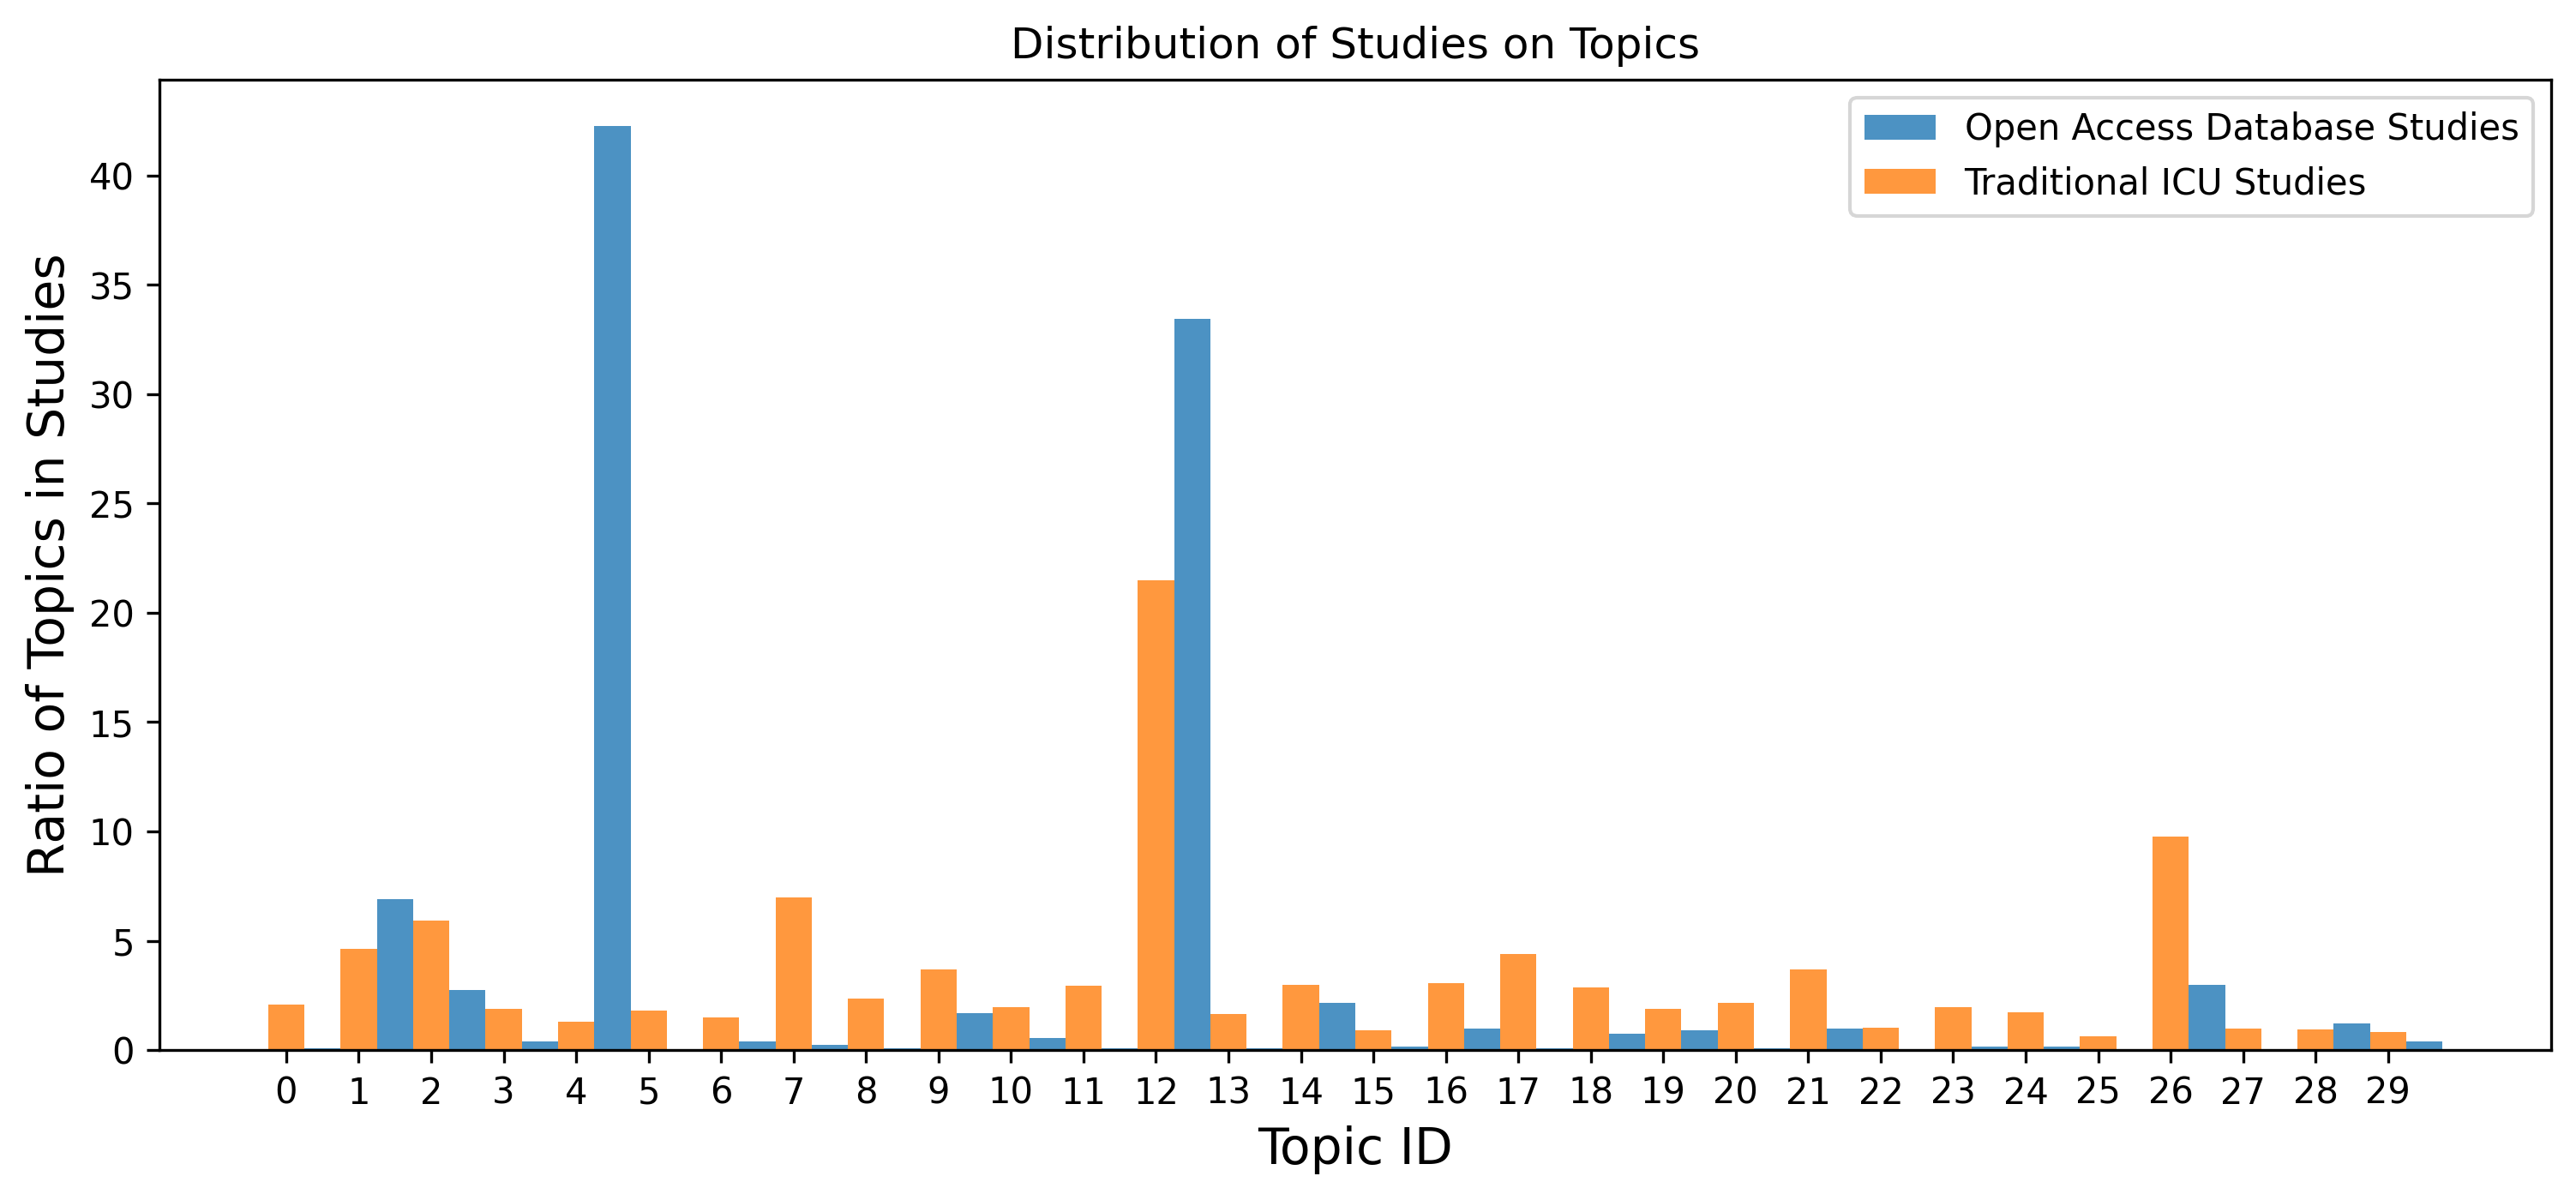

In [ ]:
fig,ax = plt.subplots(figsize=(12,5),dpi=300)
plt.bar(np.arange(0,30)+0.5,height=database_precentage,label="Open Access Database Studies",alpha=0.8,width=0.5)
plt.bar(np.arange(0,30),height=other_precentage,label="Traditional ICU Studies",alpha=0.8,width=0.5)
plt.xlabel("Topic ID",size=14)
plt.ylabel("Ratio of Topics in Studies",size=14)
plt.title("Distribution of Studies on Topics")
plt.xticks(np.arange(30))
plt.legend()

In [ ]:
words=[]
for i in range(10):
  word=topic_model.topic_representations_[4][i][0]
  words.append(word)

In [ ]:
scores=[]
for i in range(10):
  score=topic_model.topic_representations_[4][i][1]
  scores.append(score)

In [ ]:
words,scores

(['learning',
  'model',
  'machine',
  'machine learning',
  'models',
  'data',
  'prediction',
  'performance',
  'proposed',
  'based'],
 [0.24762436454254644,
  0.23919783724967467,
  0.2277647996671158,
  0.2208741614743188,
  0.21917924275078182,
  0.2134730718570196,
  0.2083190692676851,
  0.18523466000322705,
  0.18311637200200215,
  0.17508568370026323])

In [ ]:
embeddings=sentence_model.encode(data["Abstract"],show_progress_bar=False)

In [ ]:
reduced_embeddings=UMAP(n_neighbors=100,n_components=2,min_dist=0.0,metric="cosine",random_state=37).fit_transform(embeddings)

In [ ]:
topic_model.visualize_documents(data["Abstract"],reduced_embeddings=reduced_embeddings,custom_labels=True,hide_document_hover=True)

In [ ]:
prob=topic_model.probabilities_

In [ ]:
reduced_prob=UMAP(n_neighbors=100,n_components=1,min_dist=0.0,metric="cosine",random_state=37).fit_transform(prob)

In [ ]:
col=[color for name,color in mcolors.TABLEAU_COLORS.items()] 

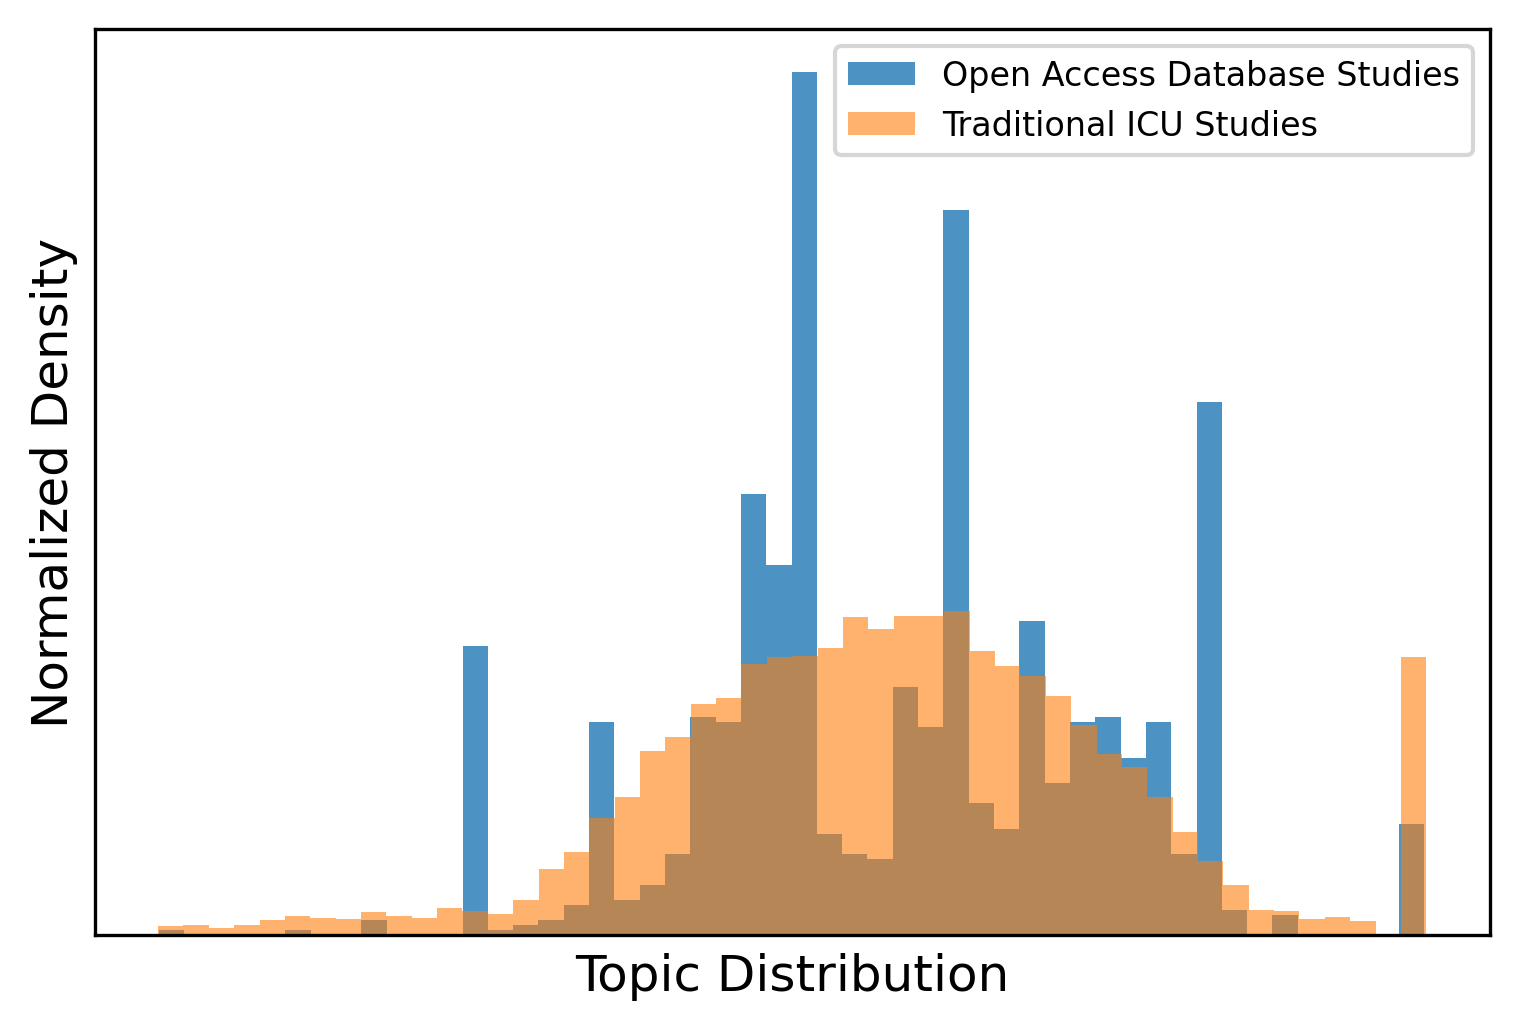

In [ ]:
fig,ax=plt.subplots(dpi=300)
database_paper=plt.hist(reduced_prob[database_index],density=True,alpha=0.8,bins=50,label='Open Access Database Studies')
other_paper=plt.hist(reduced_prob[other_index],density=True,alpha=0.6,bins=50,label='Traditional ICU Studies') 
plt.xticks([])
plt.yticks([])
plt.xlabel("Topic Distribution",size=12)
plt.ylabel("Normalized Density",size=12)
plt.legend(prop={"size":8})

In [ ]:
data.insert(1,"Topic_Family"," ")

In [ ]:
data["Topic_Family"][data[(data["Topic_Num"]==5)^(data["Topic_Num"]==7)^(data["Topic_Num"]==25)].index]="Pediatrics Care"
data["Topic_Family"][data[(data["Topic_Num"]==0)^(data["Topic_Num"]==12)].index]="Sepsis"
data["Topic_Family"][data[(data["Topic_Num"]==1)].index]="Kidney Injury"
data["Topic_Family"][data[(data["Topic_Num"]==10)^(data["Topic_Num"]==27)].index]="Nutrition and Rehabilitation"
data["Topic_Family"][data[(data["Topic_Num"]==14)].index]="Glucose Control"
data["Topic_Family"][data[(data["Topic_Num"]==18)].index]="Medication Errors"
data["Topic_Family"][data[(data["Topic_Num"]==21)].index]="Traumatic Brain Injury"
data["Topic_Family"][data[(data["Topic_Num"]==8)].index]="Healthcare Associated Infection"
data["Topic_Family"][data[(data["Topic_Num"]==4)].index]="Predictive Model"
data["Topic_Family"][data[(data["Topic_Num"]==24)].index]="End of Life and Ethics"
data["Topic_Family"][data[(data["Topic_Num"]==3)].index]="Fungal Infection"
data["Topic_Family"][data[(data["Topic_Num"]==19)^(data["Topic_Num"]==26)^(data["Topic_Num"]==29)].index]="Ventilation Related"
data["Topic_Family"][data[(data["Topic_Num"]==6)^(data["Topic_Num"]==13)^(data["Topic_Num"]==23)].index]="Antibiotics Resistance"
data["Topic_Family"][data[(data["Topic_Num"]==2)].index]="Cardiac Surgies"
data["Topic_Family"][data[(data["Topic_Num"]==11)].index]="Pregnancy Related"
data["Topic_Family"][data[(data["Topic_Num"]==15)].index]="Cellular / Molecular Studies"
data["Topic_Family"][data[(data["Topic_Num"]==16)].index]="Thromboembolism"
data["Topic_Family"][data[(data["Topic_Num"]==17)].index]="Thoracic Surgeries"
data["Topic_Family"][data[(data["Topic_Num"]==20)].index]="Viral Infections"
data["Topic_Family"][data[(data["Topic_Num"]==22)].index]="Health Personnel and Psychology"
data["Topic_Family"][data[(data["Topic_Num"]==28)].index]="Obesity"
data["Topic_Family"][data[(data["Topic_Num"]==9)].index]="Delirium"

In [ ]:
topic1=data[data["Topic_Family"]=="Pediatrics Care"]
topic2=data[data["Topic_Family"]=="Sepsis"]
topic3=data[data["Topic_Family"]=="Kidney Injury"]
topic4=data[data["Topic_Family"]=="Nutrition and Rehabilitation"]
topic5=data[data["Topic_Family"]=="Glucose Control"]
topic6=data[data["Topic_Family"]=="Medical Errors"]
topic7=data[data["Topic_Family"]=="Traumatic Brain Injury"]
topic8=data[data["Topic_Family"]=="Healthcare Associated Infection"]
topic9=data[data["Topic_Family"]=="Predictive Model"]
topic10=data[data["Topic_Family"]=="End of Life and Ethics"]
topic11=data[data["Topic_Family"]=="Fungal Infection"]
topic12=data[data["Topic_Family"]=="Ventilation Related"]
topic13=data[data["Topic_Family"]=="Antibiotics Resistance"]
topic14=data[data["Topic_Family"]=="Cardiac Surgies"]
topic15=data[data["Topic_Family"]=="Pregnancy Related"]
topic16=data[data["Topic_Family"]=="Cellular / Molecular Studies"]
topic17=data[data["Topic_Family"]=="Thromboembolism"]
topic18=data[data["Topic_Family"]=="Thoracic Surgeries"]
topic19=data[data["Topic_Family"]=="Viral Infections"]
topic20=data[data["Topic_Family"]=="Health Personnel and Psychology"]
topic21=data[data["Topic_Family"]=="Obesity"]
topic22=data[data["Topic_Family"]=="Delirium"]

In [ ]:
topic1=topic1["Publication Year"].value_counts().sort_index().to_frame()
topic2=topic2["Publication Year"].value_counts().sort_index().to_frame()
topic3=topic3["Publication Year"].value_counts().sort_index().to_frame()
topic4=topic4["Publication Year"].value_counts().sort_index().to_frame()
topic5=topic5["Publication Year"].value_counts().sort_index().to_frame()
topic6=topic6["Publication Year"].value_counts().sort_index().to_frame()
topic7=topic7["Publication Year"].value_counts().sort_index().to_frame()
topic8=topic8["Publication Year"].value_counts().sort_index().to_frame()
topic9=topic9["Publication Year"].value_counts().sort_index().to_frame()
topic10=topic10["Publication Year"].value_counts().sort_index().to_frame()
topic11=topic11["Publication Year"].value_counts().sort_index().to_frame()
topic12=topic12["Publication Year"].value_counts().sort_index().to_frame()
topic13=topic13["Publication Year"].value_counts().sort_index().to_frame()
topic14=topic14["Publication Year"].value_counts().sort_index().to_frame()
topic15=topic15["Publication Year"].value_counts().sort_index().to_frame()
topic16=topic16["Publication Year"].value_counts().sort_index().to_frame()
topic17=topic17["Publication Year"].value_counts().sort_index().to_frame()
topic18=topic18["Publication Year"].value_counts().sort_index().to_frame()
topic19=topic19["Publication Year"].value_counts().sort_index().to_frame()
topic20=topic20["Publication Year"].value_counts().sort_index().to_frame()
topic21=topic21["Publication Year"].value_counts().sort_index().to_frame()
topic22=topic22["Publication Year"].value_counts().sort_index().to_frame()

Text(0.0, 1.0, 'B')

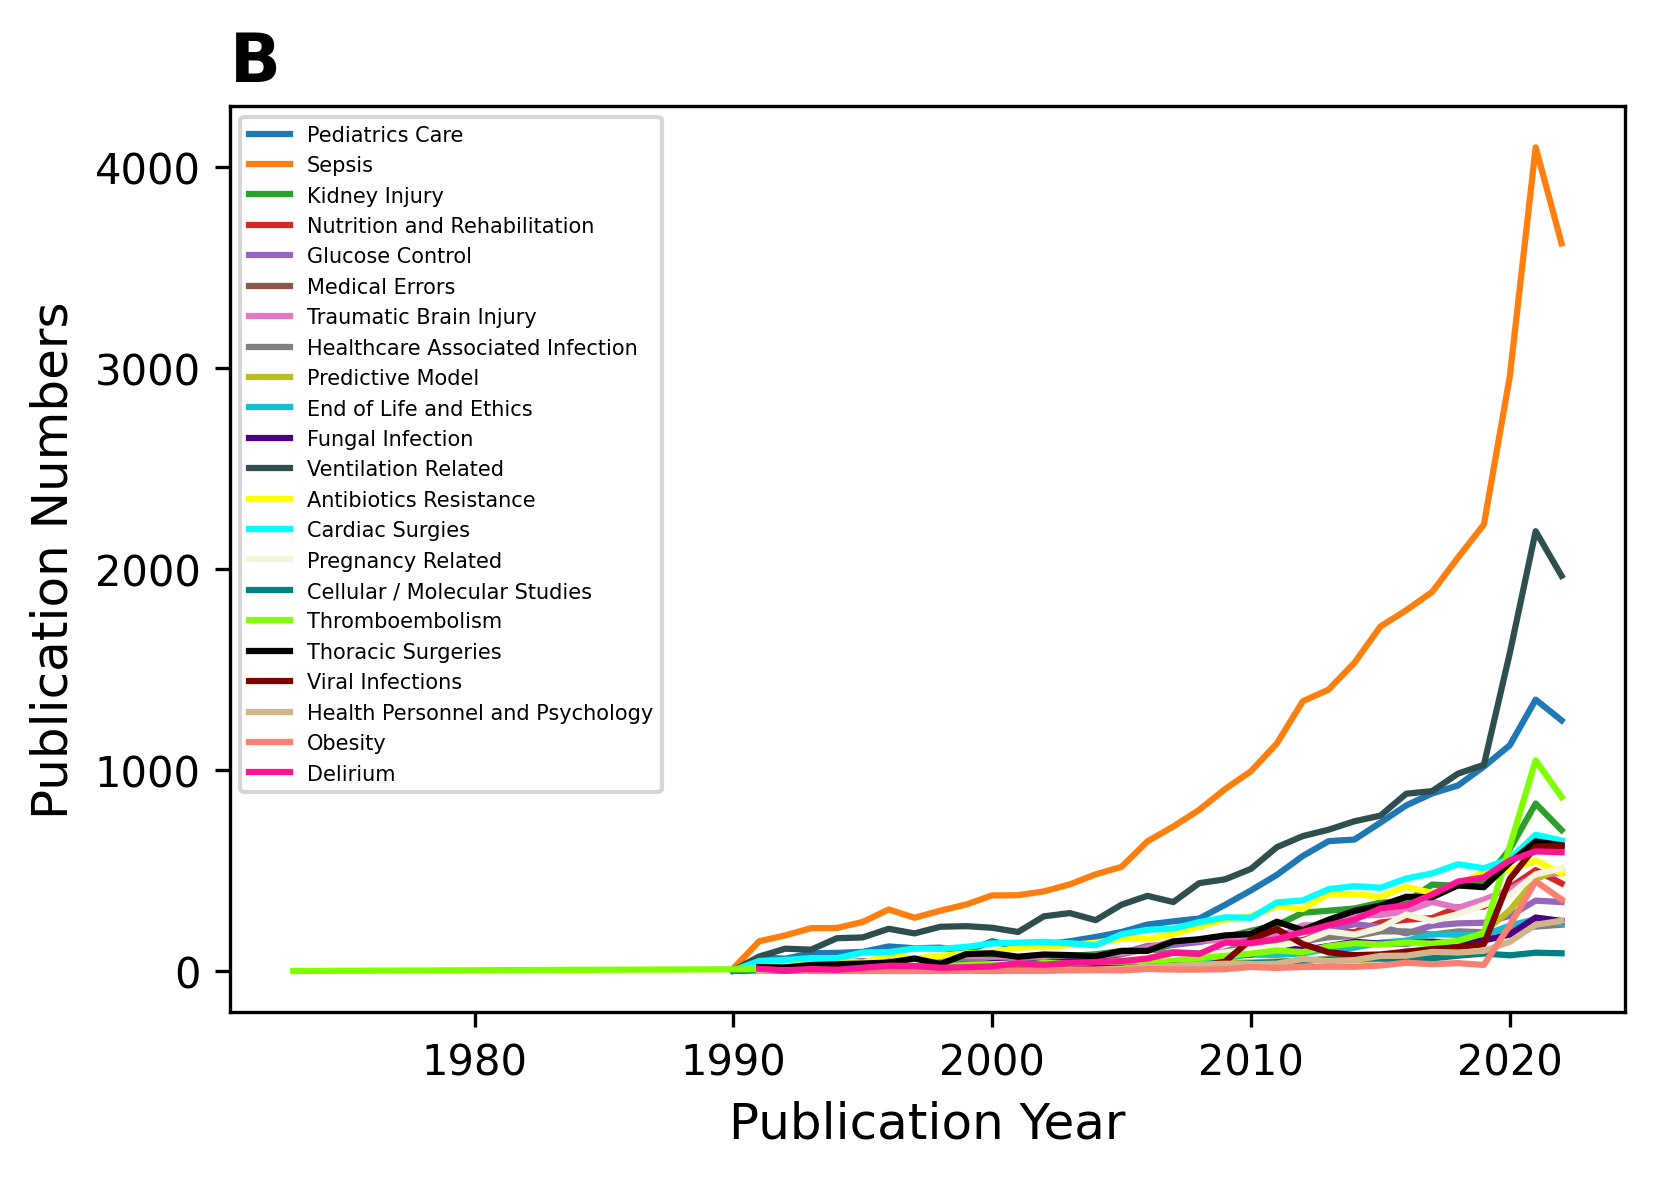

In [ ]:
plt.figure(dpi=300)
plt.plot(topic1[topic1.index<2023],label="Pediatrics Care")
plt.plot(topic2[topic2.index<2023],label="Sepsis")
plt.plot(topic3[topic3.index<2023],label="Kidney Injury")
plt.plot(topic4[topic4.index<2023],label="Nutrition and Rehabilitation")
plt.plot(topic5[topic5.index<2023],label="Glucose Control")
plt.plot(topic6[topic6.index<2023],label="Medical Errors")
plt.plot(topic7[topic7.index<2023],label="Traumatic Brain Injury")
plt.plot(topic8[topic8.index<2023],label="Healthcare Associated Infection")
plt.plot(topic9[topic9.index<2023],label="Predictive Model")
plt.plot(topic10[topic10.index<2023],label="End of Life and Ethics")
plt.plot(topic11[topic11.index<2023],label="Fungal Infection",color="Indigo")
plt.plot(topic12[topic12.index<2023],label="Ventilation Related",color="DarkSlateGray")
plt.plot(topic13[topic13.index<2023],label="Antibiotics Resistance",color="Yellow")
plt.plot(topic14[topic14.index<2023],label="Cardiac Surgies",color="Cyan")
plt.plot(topic15[topic15.index<2023],label="Pregnancy Related",color="Beige")
plt.plot(topic16[topic16.index<2023],label="Cellular / Molecular Studies",color="Teal")
plt.plot(topic17[topic17.index<2023],label="Thromboembolism",color="Chartreuse")
plt.plot(topic18[topic18.index<2023],label="Thoracic Surgeries",color="Black")
plt.plot(topic19[topic19.index<2023],label="Viral Infections",color="Maroon")
plt.plot(topic20[topic20.index<2023],label="Health Personnel and Psychology",color="Tan")
plt.plot(topic21[topic21.index<2023],label="Obesity",color="Salmon")
plt.plot(topic22[topic22.index<2023],label="Delirium",color="Deeppink")
plt.xlabel("Publication Year",size=12)
plt.ylabel("Publication Numbers",size=12)
plt.legend(prop={"size":5})
plt.title("B",loc="left",fontsize=16,fontweight="bold")

In [ ]:
data["Topic_Family"][database_index].value_counts()

Predictive Model                   550
Sepsis                             436
Kidney Injury                       90
Ventilation Related                 56
Cardiac Surgies                     36
Glucose Control                     28
Delirium                            22
Obesity                             16
Thromboembolism                     13
Traumatic Brain Injury              13
Medication Errors                   10
Antibiotics Resistance               8
Nutrition and Rehabilitation         7
Fungal Infection                     5
Pediatrics Care                      3
Cellular / Molecular Studies         2
End of Life and Ethics               2
Pregnancy Related                    1
Healthcare Associated Infection      1
Thoracic Surgeries                   1
Viral Infections                     1
Name: Topic_Family, dtype: int64

In [ ]:
data["Topic_Family"][other_index].value_counts()

Sepsis                             34259
Ventilation Related                18160
Pediatrics Care                    13734
Cardiac Surgies                     8636
Antibiotics Resistance              7399
Kidney Injury                       6756
Thoracic Surgeries                  6373
Delirium                            5394
Traumatic Brain Injury              5358
Thromboembolism                     4459
Glucose Control                     4317
Pregnancy Related                   4304
Nutrition and Rehabilitation        4281
Medication Errors                   4145
Healthcare Associated Infection     3408
Viral Infections                    3149
Fungal Infection                    2733
End of Life and Ethics              2503
Predictive Model                    1865
Health Personnel and Psychology     1518
Obesity                             1356
Cellular / Molecular Studies        1316
                                       3
Name: Topic_Family, dtype: int64

In [ ]:
data_1=data.loc[database_index]

In [ ]:
data_1[data_1["Topic_Family"]=="Predictive Model"]["Publication Year"].value_counts().sort_index()

2008.0      1
2009.0      1
2010.0      3
2011.0      1
2012.0      2
2013.0      4
2014.0      5
2015.0      8
2016.0      8
2017.0     12
2018.0     23
2019.0     46
2020.0     86
2021.0    147
2022.0    198
2023.0      5
Name: Publication Year, dtype: int64

In [ ]:
data_1[data_1["Topic_Family"]=="Sepsis"]["Publication Year"].value_counts().sort_index()

2008.0      1
2010.0      1
2011.0      1
2013.0      1
2014.0      3
2015.0      3
2016.0      4
2017.0      7
2018.0     23
2019.0     23
2020.0     55
2021.0    138
2022.0    175
2023.0      1
Name: Publication Year, dtype: int64

In [ ]:
data_1[data_1["Topic_Family"]=="Kidney Injury"]["Publication Year"].value_counts().sort_index()

2017.0     2
2018.0     5
2019.0     7
2020.0     9
2021.0    30
2022.0    37
Name: Publication Year, dtype: int64

In [ ]:
data_1[data_1["Topic_Family"]=="Ventilation Related"]["Publication Year"].value_counts().sort_index()

2017.0     1
2018.0     1
2019.0     2
2020.0     6
2021.0    15
2022.0    30
2023.0     1
Name: Publication Year, dtype: int64

In [ ]:
data_1[data_1["Topic_Family"]=="Cardiac Surgies"]["Publication Year"].value_counts().sort_index()

2004.0     1
2014.0     1
2019.0     3
2020.0     2
2021.0    11
2022.0    18
Name: Publication Year, dtype: int64

In [ ]:
data_1[data_1["Topic_Family"]=="Glucose Control"]["Publication Year"].value_counts().sort_index()


2016.0     1
2019.0     3
2020.0     5
2021.0     8
2022.0    11
Name: Publication Year, dtype: int64

In [ ]:
data_1[data_1["Topic_Family"]=="Delirium"]["Publication Year"].value_counts().sort_index()

2018.0     1
2019.0     2
2020.0     2
2021.0     6
2022.0    11
Name: Publication Year, dtype: int64

In [ ]:
data_1[data_1["Topic_Family"]=="Obesity and COVID"]["Publication Year"].value_counts().sort_index()

Series([], Name: Publication Year, dtype: int64)

In [ ]:
data_1[data_1["Topic_Family"]=="Thromboembolism"]["Publication Year"].value_counts().sort_index()

2020.0    1
2021.0    4
2022.0    8
Name: Publication Year, dtype: int64

In [ ]:
data_1[data_1["Topic_Family"]=="Traumatic Brain Injury"]["Publication Year"].value_counts().sort_index()

2015.0    1
2019.0    1
2020.0    1
2021.0    2
2022.0    7
2023.0    1
Name: Publication Year, dtype: int64

In [ ]:
data_1[data_1["Topic_Family"]=="Medication Errors"]["Publication Year"].value_counts().sort_index()

2017.0    1
2019.0    1
2021.0    4
2022.0    4
Name: Publication Year, dtype: int64

In [ ]:
data_1[data_1["Topic_Family"]=="Antibiotics Resistance"]["Publication Year"].value_counts().sort_index()

2019.0    1
2021.0    3
2022.0    4
Name: Publication Year, dtype: int64

In [ ]:
data_1[data_1["Topic_Family"]=="Nutrition and Rehabilitation"]["Publication Year"].value_counts().sort_index()

2021.0    2
2022.0    5
Name: Publication Year, dtype: int64

In [ ]:
data_1[data_1["Topic_Family"]=="Fungal Infection"]["Publication Year"].value_counts().sort_index()

2020.0    1
2021.0    1
2022.0    3
Name: Publication Year, dtype: int64

In [ ]:
data_1[data_1["Topic_Family"]=="Paediatrics Care"]["Publication Year"].value_counts().sort_index()

Series([], Name: Publication Year, dtype: int64)

In [ ]:
data_2=data.loc[other_index]

In [ ]:
data_2[data_2["Topic_Family"]=="Sepsis"]["Publication Year"].value_counts().sort_index()

1990.0      14
1991.0     149
1992.0     178
1993.0     214
1994.0     215
1995.0     245
1996.0     307
1997.0     266
1998.0     301
1999.0     332
2000.0     377
2001.0     378
2002.0     397
2003.0     432
2004.0     482
2005.0     519
2006.0     646
2007.0     720
2008.0     802
2009.0     906
2010.0     994
2011.0    1132
2012.0    1343
2013.0    1400
2014.0    1532
2015.0    1712
2016.0    1792
2017.0    1880
2018.0    2035
2019.0    2200
2020.0    2904
2021.0    3961
2022.0    3446
2023.0      48
Name: Publication Year, dtype: int64

In [ ]:
data_2[data_2["Topic_Family"]=="Ventilation Related"]["Publication Year"].value_counts().sort_index()

1990.0       4
1991.0      73
1992.0     112
1993.0     107
1994.0     164
1995.0     168
1996.0     211
1997.0     188
1998.0     221
1999.0     224
2000.0     216
2001.0     195
2002.0     273
2003.0     289
2004.0     254
2005.0     331
2006.0     375
2007.0     344
2008.0     438
2009.0     457
2010.0     509
2011.0     617
2012.0     672
2013.0     704
2014.0     746
2015.0     774
2016.0     883
2017.0     895
2018.0     982
2019.0    1025
2020.0    1576
2021.0    2174
2022.0    1937
2023.0      22
Name: Publication Year, dtype: int64

In [ ]:
data_2[data_2["Topic_Family"]=="Paediatrics Care"]["Publication Year"].value_counts().sort_index()

Series([], Name: Publication Year, dtype: int64)

In [ ]:
data_2[data_2["Topic_Family"]=="Cardiac Surgies"]["Publication Year"].value_counts().sort_index()

1990.0      4
1991.0     51
1992.0     56
1993.0     65
1994.0     65
1995.0     93
1996.0     95
1997.0    113
1998.0    111
1999.0    121
2000.0    138
2001.0    142
2002.0    146
2003.0    139
2004.0    128
2005.0    184
2006.0    206
2007.0    212
2008.0    244
2009.0    268
2010.0    266
2011.0    342
2012.0    352
2013.0    408
2014.0    422
2015.0    415
2016.0    461
2017.0    487
2018.0    532
2019.0    509
2020.0    557
2021.0    668
2022.0    632
2023.0      4
Name: Publication Year, dtype: int64

In [ ]:
data_2[data_2["Topic_Family"]=="Antibiotics Resistance"]["Publication Year"].value_counts().sort_index()

1990.0      3
1991.0     20
1992.0     31
1993.0     41
1994.0     51
1995.0     42
1996.0     80
1997.0     63
1998.0     76
1999.0     89
2000.0     94
2001.0    117
2002.0    122
2003.0    130
2004.0    142
2005.0    161
2006.0    160
2007.0    184
2008.0    222
2009.0    256
2010.0    274
2011.0    324
2012.0    309
2013.0    385
2014.0    384
2015.0    371
2016.0    420
2017.0    389
2018.0    428
2019.0    494
2020.0    504
2021.0    547
2022.0    483
2023.0      3
Name: Publication Year, dtype: int64

In [ ]:
data_2[data_2["Topic_Family"]=="Kidney Injury"]["Publication Year"].value_counts().sort_index()

1990.0      3
1991.0     25
1992.0     25
1993.0     25
1994.0     39
1995.0     39
1996.0     41
1997.0     44
1998.0     53
1999.0     56
2000.0     65
2001.0     59
2002.0     78
2003.0     76
2004.0     84
2005.0    100
2006.0    104
2007.0    132
2008.0    155
2009.0    168
2010.0    201
2011.0    228
2012.0    291
2013.0    301
2014.0    312
2015.0    341
2016.0    345
2017.0    429
2018.0    419
2019.0    440
2020.0    598
2021.0    804
2022.0    665
2023.0     11
Name: Publication Year, dtype: int64

In [ ]:
data_2[data_2["Topic_Family"]=="Thoracic Surgeries"]["Publication Year"].value_counts().sort_index()

1991.0     20
1992.0     19
1993.0     31
1994.0     35
1995.0     38
1996.0     43
1997.0     63
1998.0     36
1999.0     85
2000.0     89
2001.0     72
2002.0     83
2003.0     80
2004.0     74
2005.0    101
2006.0    101
2007.0    148
2008.0    159
2009.0    178
2010.0    185
2011.0    246
2012.0    204
2013.0    256
2014.0    300
2015.0    326
2016.0    370
2017.0    368
2018.0    427
2019.0    418
2020.0    540
2021.0    646
2022.0    625
2023.0      7
Name: Publication Year, dtype: int64

In [ ]:
data_2[data_2["Topic_Family"]=="Delirium"]["Publication Year"].value_counts().sort_index()

1991.0     12
1992.0      4
1993.0     11
1994.0      7
1995.0     17
1996.0     27
1997.0     26
1998.0     17
1999.0     20
2000.0     24
2001.0     40
2002.0     32
2003.0     41
2004.0     46
2005.0     50
2006.0     63
2007.0     92
2008.0     86
2009.0    142
2010.0    139
2011.0    159
2012.0    195
2013.0    229
2014.0    257
2015.0    312
2016.0    327
2017.0    382
2018.0    445
2019.0    465
2020.0    549
2021.0    590
2022.0    581
2023.0      7
Name: Publication Year, dtype: int64

In [ ]:
data_2[data_2["Topic_Family"]=="Traumatic Brain Injury"]["Publication Year"].value_counts().sort_index()

1990.0      3
1991.0     16
1992.0     22
1993.0     28
1994.0     24
1995.0     37
1996.0     42
1997.0     45
1998.0     44
1999.0     61
2000.0     52
2001.0     60
2002.0     71
2003.0     73
2004.0     76
2005.0     86
2006.0    115
2007.0    149
2008.0    154
2009.0    154
2010.0    191
2011.0    165
2012.0    228
2013.0    229
2014.0    275
2015.0    279
2016.0    298
2017.0    345
2018.0    315
2019.0    355
2020.0    405
2021.0    474
2022.0    482
2023.0      5
Name: Publication Year, dtype: int64

In [ ]:
data_2[data_2["Topic_Family"]=="Thromboembolism"]["Publication Year"].value_counts().sort_index()

1973.0       1
1991.0      10
1992.0      10
1993.0      21
1994.0      11
1995.0      24
1996.0      14
1997.0      19
1998.0      24
1999.0      30
2000.0      34
2001.0      25
2002.0      42
2003.0      36
2004.0      41
2005.0      47
2006.0      41
2007.0      52
2008.0      66
2009.0      76
2010.0      87
2011.0     103
2012.0      95
2013.0     124
2014.0     139
2015.0     133
2016.0     142
2017.0     137
2018.0     151
2019.0     189
2020.0     620
2021.0    1045
2022.0     859
2023.0      11
Name: Publication Year, dtype: int64

In [ ]:
data_2[data_2["Topic_Family"]=="Glucose Control"]["Publication Year"].value_counts().sort_index()

1991.0     25
1992.0     28
1993.0     36
1994.0     43
1995.0     50
1996.0     50
1997.0     40
1998.0     38
1999.0     46
2000.0     43
2001.0     51
2002.0     56
2003.0     61
2004.0     53
2005.0     89
2006.0    126
2007.0    131
2008.0    145
2009.0    167
2010.0    163
2011.0    184
2012.0    196
2013.0    201
2014.0    234
2015.0    220
2016.0    187
2017.0    227
2018.0    238
2019.0    238
2020.0    270
2021.0    343
2022.0    333
2023.0      5
Name: Publication Year, dtype: int64

In [ ]:
data_2[data_2["Topic_Family"]=="Pregnancy Related"]["Publication Year"].value_counts().sort_index()

1990.0      1
1991.0     17
1992.0     24
1993.0     25
1994.0     24
1995.0     29
1996.0     28
1997.0     35
1998.0     34
1999.0     28
2000.0     34
2001.0     39
2002.0     34
2003.0     35
2004.0     41
2005.0     53
2006.0     80
2007.0     60
2008.0     87
2009.0     93
2010.0    112
2011.0    124
2012.0    148
2013.0    197
2014.0    182
2015.0    215
2016.0    282
2017.0    250
2018.0    284
2019.0    329
2020.0    377
2021.0    482
2022.0    512
2023.0      9
Name: Publication Year, dtype: int64

In [ ]:
data_2[data_2["Topic_Family"]=="Nutrition and Rehabilitation"]["Publication Year"].value_counts().sort_index()

1990.0      2
1991.0     14
1992.0     13
1993.0     22
1994.0     14
1995.0     22
1996.0     24
1997.0     31
1998.0     21
1999.0     33
2000.0     27
2001.0     25
2002.0     31
2003.0     39
2004.0     46
2005.0     57
2006.0     58
2007.0     68
2008.0     82
2009.0     97
2010.0    105
2011.0    145
2012.0    155
2013.0    195
2014.0    194
2015.0    242
2016.0    256
2017.0    264
2018.0    318
2019.0    321
2020.0    416
2021.0    501
2022.0    432
2023.0     11
Name: Publication Year, dtype: int64

In [ ]:
data_2[data_2["Topic_Family"]=="Medication Errors"]["Publication Year"].value_counts().sort_index()

1979.0      1
1990.0      2
1991.0     23
1992.0     33
1993.0     30
1994.0     32
1995.0     44
1996.0     37
1997.0     40
1998.0     47
1999.0     64
2000.0     56
2001.0     54
2002.0     37
2003.0     61
2004.0     68
2005.0     85
2006.0     81
2007.0     73
2008.0    118
2009.0    109
2010.0    137
2011.0    151
2012.0    159
2013.0    190
2014.0    190
2015.0    213
2016.0    226
2017.0    252
2018.0    236
2019.0    296
2020.0    314
2021.0    356
2022.0    325
2023.0      5
Name: Publication Year, dtype: int64

In [ ]:
data_2[data_2["Topic_Family"]=="Healthcare Associated Infection"]["Publication Year"].value_counts().sort_index()

1990.0      1
1991.0     23
1992.0     21
1993.0     29
1994.0     38
1995.0     33
1996.0     49
1997.0     32
1998.0     38
1999.0     45
2000.0     43
2001.0     44
2002.0     42
2003.0     74
2004.0     58
2005.0     59
2006.0     83
2007.0     94
2008.0     89
2009.0     96
2010.0    146
2011.0    146
2012.0    148
2013.0    169
2014.0    174
2015.0    198
2016.0    198
2017.0    182
2018.0    198
2019.0    194
2020.0    208
2021.0    221
2022.0    231
2023.0      4
Name: Publication Year, dtype: int64

In [ ]:
data_2[data_2["Topic_Family"]=="Viral Infections"]["Publication Year"].value_counts().sort_index()

1991.0      2
1992.0      2
1993.0      5
1994.0      8
1995.0      1
1996.0      4
1997.0      3
1998.0      8
1999.0      6
2000.0      9
2001.0      7
2002.0     10
2003.0      8
2004.0     15
2005.0     16
2006.0     21
2007.0     27
2008.0     25
2009.0     48
2010.0    157
2011.0    210
2012.0    135
2013.0     94
2014.0     80
2015.0     83
2016.0     97
2017.0    110
2018.0    119
2019.0    135
2020.0    459
2021.0    618
2022.0    623
2023.0      4
Name: Publication Year, dtype: int64

In [ ]:
data_2[data_2["Topic_Family"]=="Fungal Infection"]["Publication Year"].value_counts().sort_index()

1990.0      2
1991.0      6
1992.0     16
1993.0     16
1994.0     15
1995.0     11
1996.0     21
1997.0     22
1998.0     30
1999.0     23
2000.0     40
2001.0     39
2002.0     40
2003.0     48
2004.0     45
2005.0     55
2006.0     60
2007.0     80
2008.0     84
2009.0     88
2010.0     83
2011.0    123
2012.0    105
2013.0    125
2014.0    146
2015.0    137
2016.0    138
2017.0    147
2018.0    137
2019.0    153
2020.0    181
2021.0    266
2022.0    247
2023.0      4
Name: Publication Year, dtype: int64

In [ ]:
data_2[data_2["Topic_Family"]=="End of Life and Ethics"]["Publication Year"].value_counts().sort_index()

1991.0      6
1992.0      4
1993.0      7
1994.0      7
1995.0     10
1996.0      8
1997.0      9
1998.0     16
1999.0     12
2000.0     14
2001.0     22
2002.0     11
2003.0     22
2004.0     35
2005.0     36
2006.0     48
2007.0     64
2008.0     61
2009.0     67
2010.0     83
2011.0     81
2012.0     89
2013.0    111
2014.0    117
2015.0    142
2016.0    152
2017.0    184
2018.0    181
2019.0    178
2020.0    226
2021.0    259
2022.0    238
2023.0      3
Name: Publication Year, dtype: int64

In [ ]:
data_2[data_2["Topic_Family"]=="Predictive Model"]["Publication Year"].value_counts().sort_index()

1990.0      3
1991.0     16
1992.0      9
1993.0      6
1994.0      9
1995.0      9
1996.0      9
1997.0     14
1998.0     14
1999.0     13
2000.0     12
2001.0     21
2002.0     13
2003.0     11
2004.0     13
2005.0     16
2006.0     13
2007.0     19
2008.0     37
2009.0     39
2010.0     41
2011.0     48
2012.0     46
2013.0     58
2014.0     50
2015.0     52
2016.0     92
2017.0     79
2018.0    105
2019.0    149
2020.0    217
2021.0    311
2022.0    313
2023.0      8
Name: Publication Year, dtype: int64

In [ ]:
data_2[data_2["Topic_Family"]=="Health Personnel and Psychology"]["Publication Year"].value_counts().sort_index()

1991.0      1
1992.0      4
1993.0      2
1994.0      3
1995.0      5
1996.0      8
1997.0      8
1998.0      6
1999.0      7
2000.0      5
2001.0      3
2002.0      4
2003.0      8
2004.0      8
2005.0     13
2006.0     23
2007.0     26
2008.0     33
2009.0     37
2010.0     35
2011.0     37
2012.0     61
2013.0     50
2014.0     55
2015.0     76
2016.0     77
2017.0     96
2018.0     93
2019.0    101
2020.0    146
2021.0    231
2022.0    251
2023.0      5
Name: Publication Year, dtype: int64

In [ ]:
data_2[data_2["Topic_Family"]=="Obesity and COVID"]["Publication Year"].value_counts().sort_index()

Series([], Name: Publication Year, dtype: int64)

In [ ]:
data_2[data_2["Topic_Family"]=="Cellular / Molecular Studies"]["Publication Year"].value_counts().sort_index()

1990.0     2
1991.0     5
1992.0    12
1993.0    16
1994.0    15
1995.0    22
1996.0    17
1997.0    24
1998.0    25
1999.0    32
2000.0    24
2001.0    27
2002.0    17
2003.0    32
2004.0    28
2005.0    34
2006.0    35
2007.0    29
2008.0    21
2009.0    33
2010.0    39
2011.0    45
2012.0    54
2013.0    58
2014.0    62
2015.0    64
2016.0    54
2017.0    64
2018.0    77
2019.0    87
2020.0    79
2021.0    92
2022.0    89
2023.0     2
Name: Publication Year, dtype: int64

In [ ]:
database_topic=((data["Topic_Family"][database_index].value_counts()/database_index.shape[0])*100).to_frame()
database_topic

,Topic_Family
Predictive Model,42.275173
Sepsis,33.512683
Kidney Injury,6.917756
Ventilation Related,4.304381
Cardiac Surgies,2.767102
Glucose Control,2.152191
Delirium,1.691007
Obesity,1.229823
Thromboembolism,0.999231
Traumatic Brain Injury,0.999231


In [ ]:
other_topic=((data["Topic_Family"][other_index].value_counts()/len(other_index))*100).to_frame()
other_topic

,Topic_Family
Sepsis,23.557686
Ventilation Related,12.487451
Pediatrics Care,9.443978
Cardiac Surgies,5.938415
Antibiotics Resistance,5.087811
Kidney Injury,4.645662
Thoracic Surgeries,4.382298
Delirium,3.709103
Traumatic Brain Injury,3.684348
Thromboembolism,3.066164


(0.0, 45.0)

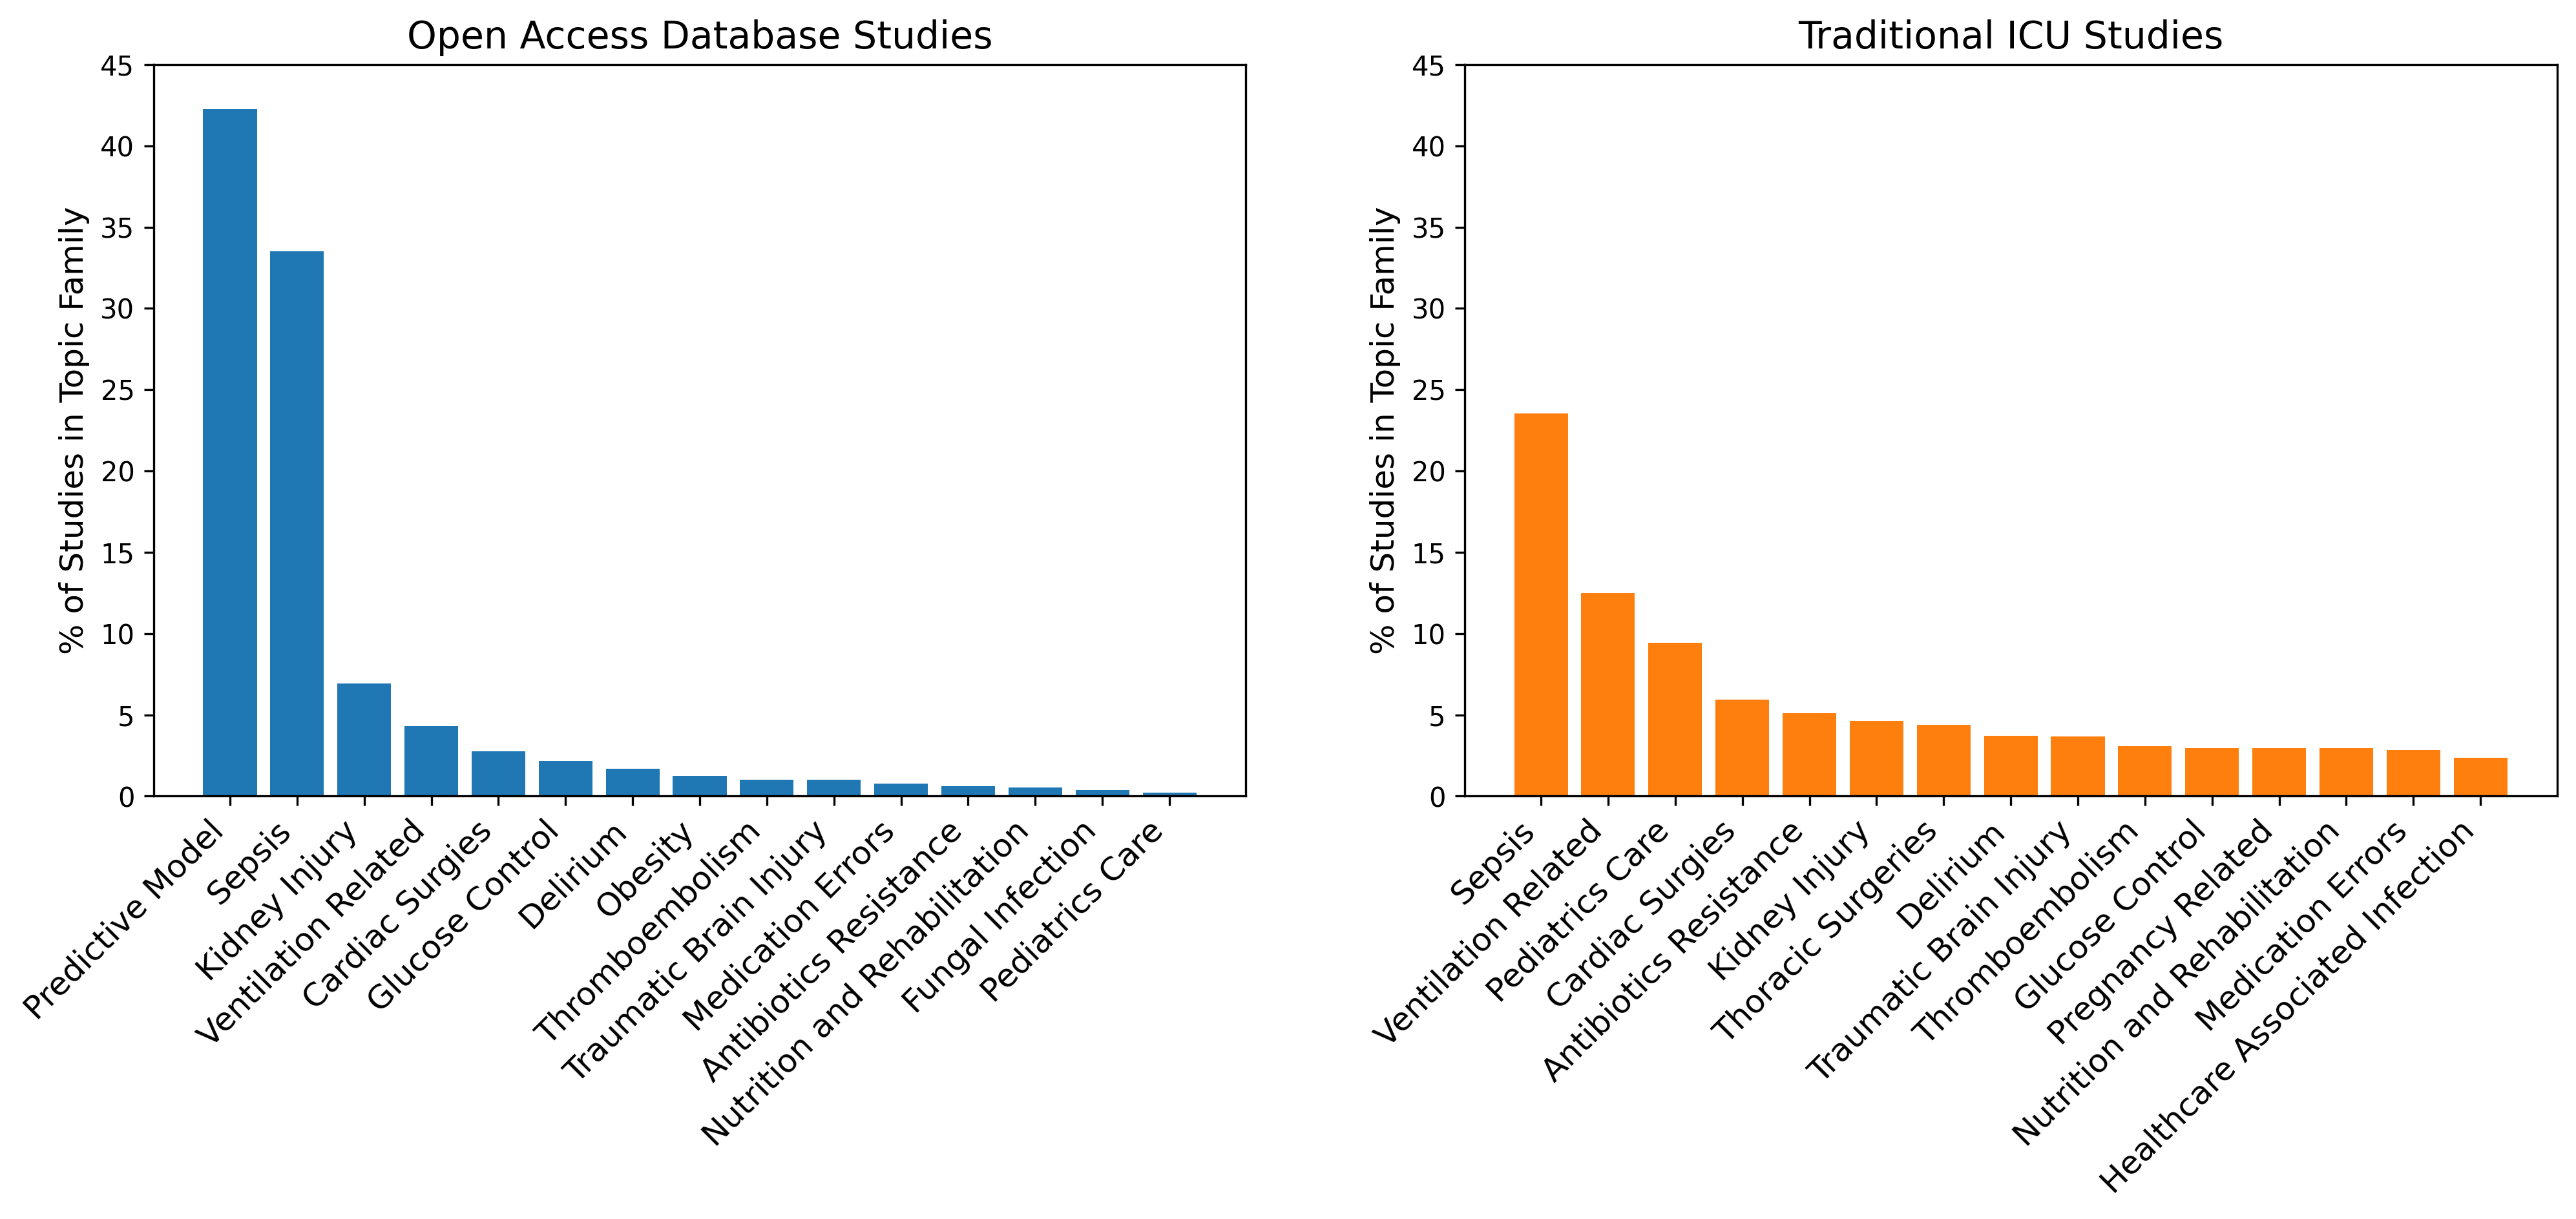

In [ ]:
fig,ax=plt.subplots(1,2,figsize=(16,5),dpi=300)
ax[0].bar(database_topic.index[:15],database_topic["Topic_Family"][:15],color=col[0])
ax[0].set_ylabel("% of Studies in Topic Family",size=12)
ax[0].set_xticklabels(database_topic.index,rotation=45,ha="right",size=12)
ax[0].set_title("Open Access Database Studies",size=14)
ax[0].set_ylim(0,45)

ax[1].bar(other_topic.index[:15],other_topic["Topic_Family"][:15],color=col[1])
ax[1].set_ylabel("% of Studies in Topic Family",size=12)
ax[1].set_xticklabels(other_topic.index,rotation=45,ha="right",size=12)
ax[1].set_title("Traditional ICU Studies",size=14)
ax[1].set_ylim(0,45)